In [1]:
# Step 1: Set up Kaggle API for dataset download
!git clone https://github.com/niaz1971/BRAIN_TUMOR_DETECTION_USING_DEEP_LEARNING.git

Cloning into 'BRAIN_TUMOR_DETECTION_USING_DEEP_LEARNING'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (307/307), done.
remote: Total 312 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (312/312), 16.25 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
cd BRAIN_TUMOR_DETECTION_USING_DEEP_LEARNING

/content/BRAIN_TUMOR_DETECTION_USING_DEEP_LEARNING


In [3]:
!pip install lime kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip
!rm brain-tumor-mri-dataset.zip
!mkdir brain-tumor-mri-dataset
!mv Training brain-tumor-mri-dataset/
!mv Testing brain-tumor-mri-dataset/
!rm kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9cb44403226679054fd350cbc922ef5ca22a46fa398b76e46cc1def299e12888
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 93% 138M/149M [00:00<00:00, 1.44GB/s]
100% 149M/149M [00:00<00:00, 1.42GB/s]


In [6]:
# === General Imports ===
import os
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
# === Visualization Libraries ===
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# === Ignore Warnings ===
warnings.filterwarnings("ignore")

# === Keras Model Utilities ===
from keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import legacy


# === Callbacks for Training ===
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)

# === Evaluation Metrics ===
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# === Image Data Preprocessing ===
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array, array_to_img
)

## Import and preview the dataset

In [7]:
# === Extract class labels from Training folder ===

# Path to the dataset root (from Kaggle download)
filename = 'brain-tumor-mri-dataset'

# Get all sub-folder names in the Training folder
classes = []
train_path = os.path.join(filename, 'Training')

for sub_folder in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, sub_folder)):
        classes.append(sub_folder)

# Print detected class names
print("Detected Classes:", classes)


Detected Classes: ['pituitary', 'glioma', 'meningioma', 'notumor']


In [8]:
train_path='brain-tumor-mri-dataset/Training/'
test_path='brain-tumor-mri-dataset/Testing/'

In [9]:
img_list = []
label_list = []

for label in classes:
    label_folder = os.path.join(train_path, label)
    for img_file in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_file)
        img_list.append(img_path)
        label_list.append(label)

print(f"Total images: {len(img_list)}")
print(f"Sample image path: {img_list[0]}")
print(f"Sample label: {label_list[0]}")


Total images: 5712
Sample image path: brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1115.jpg
Sample label: pituitary


In [10]:
train_data = pd.DataFrame({'Image':img_list,'Label':label_list})
train_data

Image      Label
0     brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
1     brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
2     brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
3     brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
4     brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
...                                                 ...        ...
5707  brain-tumor-mri-dataset/Training/notumor/Tr-no...    notumor
5708  brain-tumor-mri-dataset/Training/notumor/Tr-no...    notumor
5709  brain-tumor-mri-dataset/Training/notumor/Tr-no...    notumor
5710  brain-tumor-mri-dataset/Training/notumor/Tr-no...    notumor
5711  brain-tumor-mri-dataset/Training/notumor/Tr-no...    notumor

[5712 rows x 2 columns]

In [11]:
print(train_data.shape)
print(train_data['Label'].value_counts())
train_data.head()


(5712, 2)
Label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


Image      Label
0  brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
1  brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
2  brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
3  brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary
4  brain-tumor-mri-dataset/Training/pituitary/Tr-...  pituitary

In [12]:
img_list = []
label_list = []

for label in classes:
    label_folder = os.path.join(test_path, label)
    for img_file in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_file)
        img_list.append(img_path)
        label_list.append(label)

print(f" Total test images: {len(img_list)}")
print(f" First test image path: {img_list[0]}")
print(f" First test label: {label_list[0]}")


 Total test images: 1311
 First test image path: brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0208.jpg
 First test label: pituitary


In [13]:
test_data = pd.DataFrame({'Image':img_list,'Label':label_list})
test_data

Image      Label
0     brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
1     brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
2     brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
3     brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
4     brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
...                                                 ...        ...
1306  brain-tumor-mri-dataset/Testing/notumor/Te-no_...    notumor
1307  brain-tumor-mri-dataset/Testing/notumor/Te-no_...    notumor
1308  brain-tumor-mri-dataset/Testing/notumor/Te-no_...    notumor
1309  brain-tumor-mri-dataset/Testing/notumor/Te-no_...    notumor
1310  brain-tumor-mri-dataset/Testing/notumor/Te-no_...    notumor

[1311 rows x 2 columns]

In [14]:
print(test_data.shape)               # Show rows & columns
print(test_data['Label'].value_counts())  # Class distribution
test_data.head()                    # Preview first few rows


(1311, 2)
Label
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64


Image      Label
0  brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
1  brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
2  brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
3  brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary
4  brain-tumor-mri-dataset/Testing/pituitary/Te-p...  pituitary

## Data Exploration or Data Visualization

In [15]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):

    plt.figure(figsize=(Columns * 4, Rows * 4))
    image_count = 1

    for directory in sorted(os.listdir(BASE_URL)):
        dir_path = os.path.join(BASE_URL, directory)
        if os.path.isdir(dir_path) and directory[0] != '.':
            images = os.listdir(dir_path)
            if images:
                random_file = np.random.choice(images)
                img_path = os.path.join(dir_path, random_file)

                plt.subplot(Rows, Columns, image_count)
                image = plt.imread(img_path)
                plt.imshow(image)
                plt.title(directory)
                plt.axis('off')

                image_count += 1
                if image_count > Rows * Columns:
                    break

    plt.tight_layout()
    plt.show()


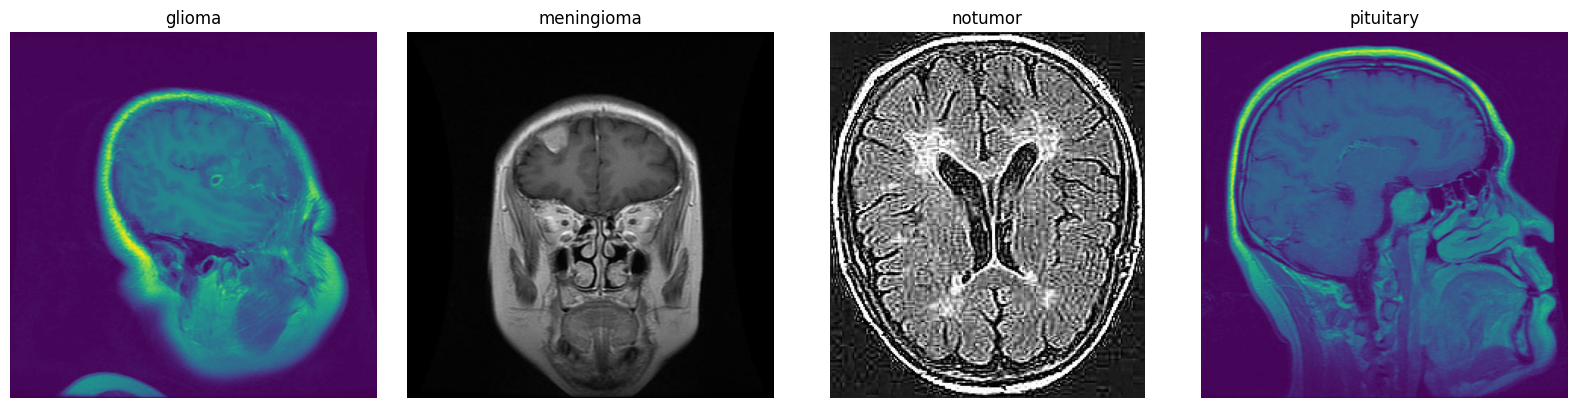

In [16]:
Plot_Classes(train_path)

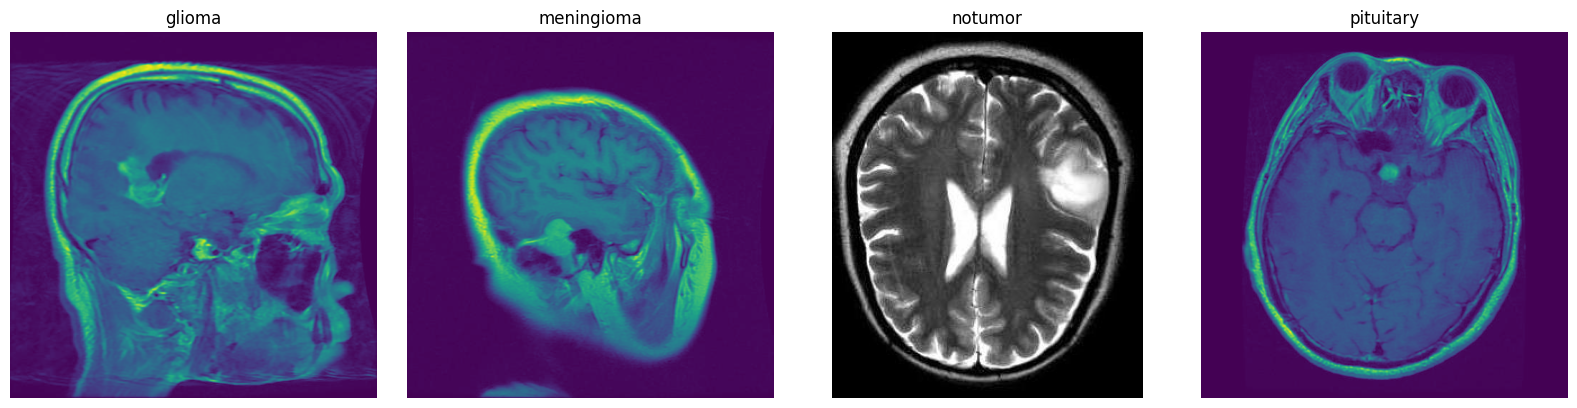

In [17]:
Plot_Classes(test_path)

In [18]:
train_data['Label'].value_counts()

Label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [19]:
px.histogram(train_data, y="Label", color="Label", title="Classes Distribution")

In [20]:
test_data['Label'].value_counts()

Label
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64

In [21]:
px.histogram(test_data, y="Label", color="Label", title="Classes Distribution")

## Data Preprocessing

In [22]:
# Define input image dimensions (width, height)
image_size = (150, 150)  # Can also use (224, 224) for pretrained models like VGG, ResNet

# Set the batch size for training
batch_size = 32  # Common values: 16, 32, 64 depending on memory/GPU


In [23]:
# ----------------------------
# Data Augmentation for Training
# ----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,         # 15% for validation from training set
    rotation_range=10,             # Random rotation in range [-10, 10]
    brightness_range=(0.85, 1.15), # Random brightness adjustment
    width_shift_range=0.002,       # Slight horizontal shift
    height_shift_range=0.002,      # Slight vertical shift
    shear_range=12.5,              # Shearing for distortion
    zoom_range=0.0,                # No zoom
    horizontal_flip=True,          # Flip horizontally
    vertical_flip=False,           # Don't flip vertically (not suitable for most medical/natural images)
    fill_mode="nearest"            # Fill in missing pixels
)

# ----------------------------
# Preprocessing for Validation (No Augmentation)
# ----------------------------
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

# ----------------------------
# Training Data Generator
# ----------------------------
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=0
)

# ----------------------------
# Validation Data Generator
# ----------------------------
val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=0
)

# ----------------------------
# Test Data Generator (Only Rescale)
# ----------------------------
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=0
)


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [24]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]
    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()


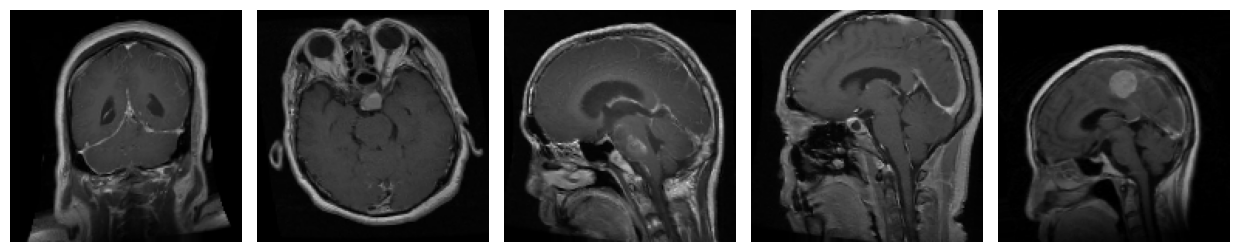

In [25]:
show_ImageDataGenerator(train_generator, num_samples=5, figsize=(12.5, 8), save=False)

### Training Setup

In [26]:
# Define full image shape (height, width, channels)
image_shape = (image_size[0], image_size[1], 3)

# Summary
print("Dataset Summary")
print(f"Image shape              : {image_shape}")
print(f"Batch size               : {batch_size}")
print(f"Number of training batches   : {len(train_generator)}")
print(f"Number of validation batches : {len(val_generator)}")
print(f"Number of testing batches    : {len(test_generator)}")

Dataset Summary
Image shape              : (150, 150, 3)
Batch size               : 32
Number of training batches   : 152
Number of validation batches : 27
Number of testing batches    : 41


In [27]:
# Get class-to-index mapping from training generator
Classes_Map = train_generator.class_indices

# Total number of classes
num_classes = len(Classes_Map)

# Display results
print(f"Number of Classes: {num_classes}")
print("Class Index Mapping:")
for class_name, index in Classes_Map.items():
    print(f"  {index} → {class_name}")

Number of Classes: 4
Class Index Mapping:
  0 → glioma
  1 → meningioma
  2 → notumor
  3 → pituitary


In [28]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(loss))

    plt.figure(figsize=(15, 5))
    plt.style.use('ggplot')

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'o-', color='#1f77b4', label="Train Loss")        # Blue
    plt.plot(epochs, val_loss, 'o-', color='#d62728', label="Val Loss")      # Red
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'o-', color='#2ca02c', label="Train Accuracy")  # Green
    plt.plot(epochs, val_accuracy, 'o-', color='#9467bd', label="Val Accuracy")# Purple
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.style.use('default')
    plt.show()


In [29]:
def CM(model, test_generator, categories):

    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    print(f"Classification Report for {model}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return confusion_matrix_array


def calculate_metrics(confusion_matrix, categories):

    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"\n ***********************************")
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

#VGG16 Model

In [30]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the VGG16 base model with pretrained ImageNet weights, exclude the top fully connected layers
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers except last 10 layers
for layer in base_model_vgg16.layers[:-10]:
    layer.trainable = False

for layer in base_model_vgg16.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=output)

# Compile the model
model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 13,701,636 (52.27 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [31]:
vgg16_history = model_vgg16.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 87s 454ms/step - accuracy: 0.6642 - loss: 0.7991 - val_accuracy: 0.8070 - val_loss: 0.4840
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 48s 313ms/step - accuracy: 0.9004 - loss: 0.2686 - val_accuracy: 0.9018 - val_loss: 0.3457


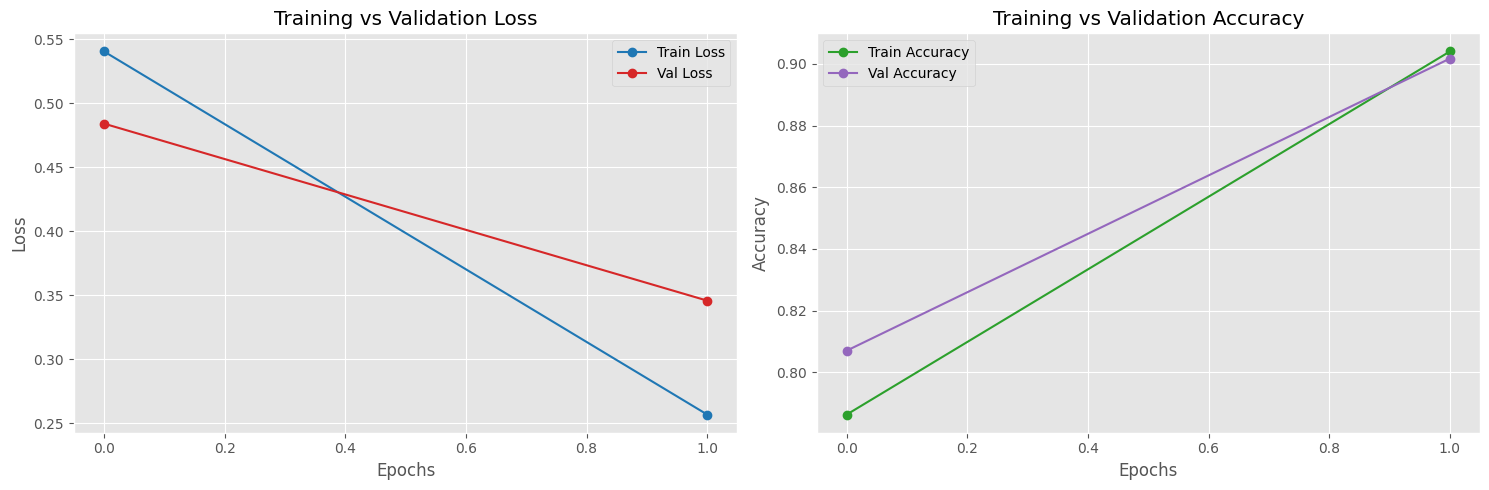

In [32]:
plot_curves(vgg16_history)

In [33]:
loss, accuracy = model_vgg16.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - accuracy: 0.8821 - loss: 0.2514
 Test Loss     : 0.19795
 Test Accuracy : 0.92372


In [34]:
# Plotting confusion matrix
confusion_matrix = CM(model=model_vgg16, test_generator=test_generator, categories=classes)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step
Classification Report for <Functional name=functional, built=True>:
              precision    recall  f1-score   support

   pituitary       0.97      0.82      0.89       300
      glioma       0.80      0.95      0.87       306
  meningioma       0.98      0.96      0.97       405
     notumor       0.96      0.96      0.96       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



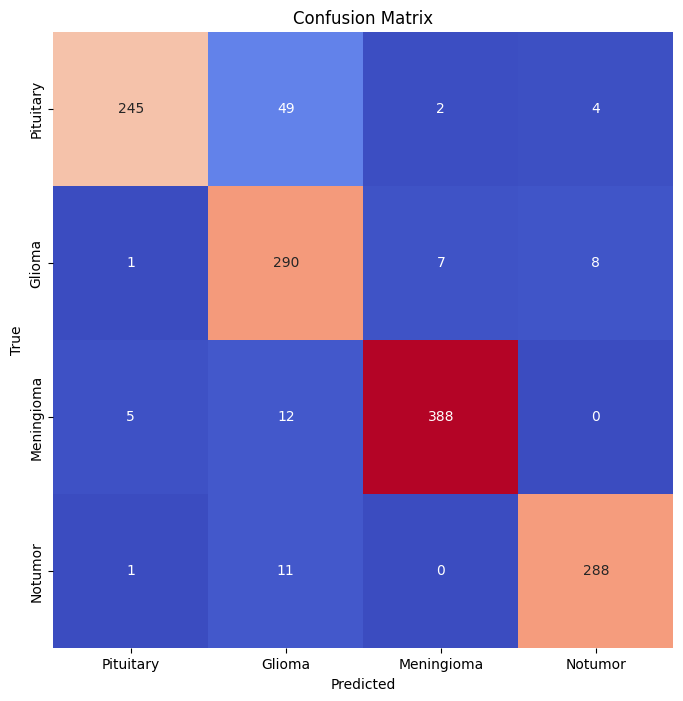

In [35]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

## VGG19 Model

In [36]:
# Load VGG19 base model with pretrained ImageNet weights
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze earlier layers for transfer learning (you can fine-tune later)
for layer in base_model_vgg.layers[:-10]:
    layer.trainable = False

for layer in base_model_vgg.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model
model_vgg19 = Model(inputs=base_model_vgg.input, outputs=output)

# Compile the model
model_vgg19.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Print summary
model_vgg19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,289,092 (77.40 MB)

 Trainable params: 17,963,524 (68.53 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

In [37]:
vgg19_history = model_vgg19.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 61s 355ms/step - accuracy: 0.6605 - loss: 0.7837 - val_accuracy: 0.7848 - val_loss: 0.5748
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 49s 320ms/step - accuracy: 0.8941 - loss: 0.3071 - val_accuracy: 0.8854 - val_loss: 0.3487


### VGG19 Model Evaluation

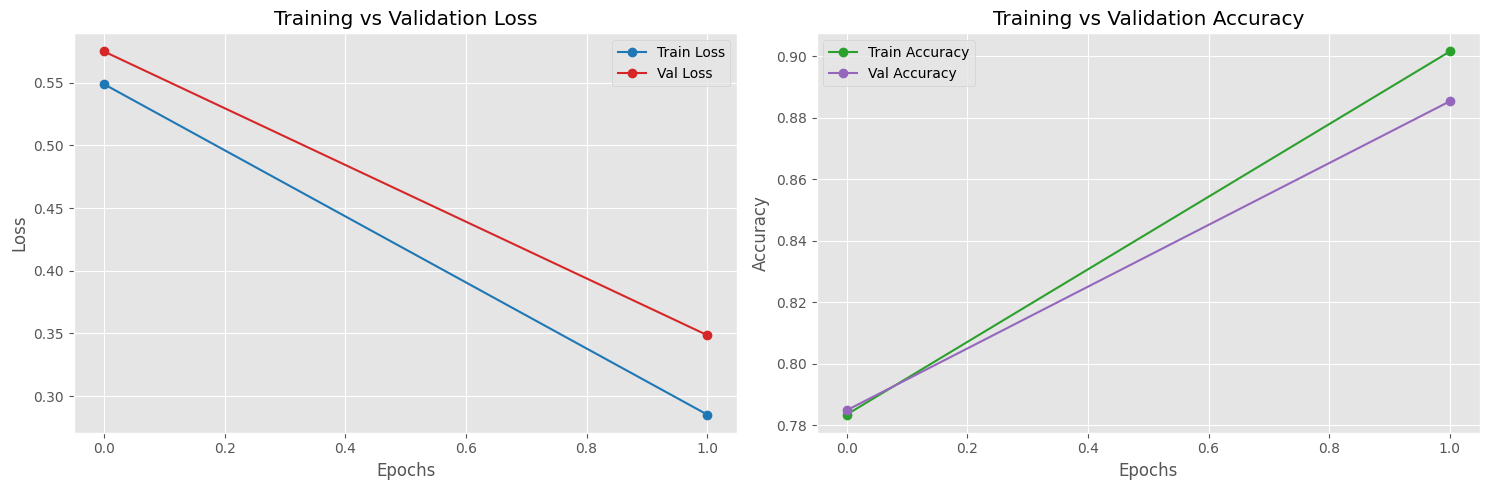

In [38]:
plot_curves(vgg19_history)

In [39]:
# Evaluate the model on the test set
loss, accuracy = model_vgg19.evaluate(test_generator)

# Display results with formatting
print(f"Test Loss     : {loss:.5f}")
print(f"Test Accuracy : {accuracy:.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.8315 - loss: 0.3954
Test Loss     : 0.28191
Test Accuracy : 0.89092


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step
Classification Report for <Functional name=functional_1, built=True>:
              precision    recall  f1-score   support

   pituitary       0.98      0.76      0.86       300
      glioma       0.77      0.85      0.81       306
  meningioma       0.93      0.96      0.95       405
     notumor       0.90      0.97      0.93       300

    accuracy                           0.89      1311
   macro avg       0.90      0.89      0.89      1311
weighted avg       0.90      0.89      0.89      1311



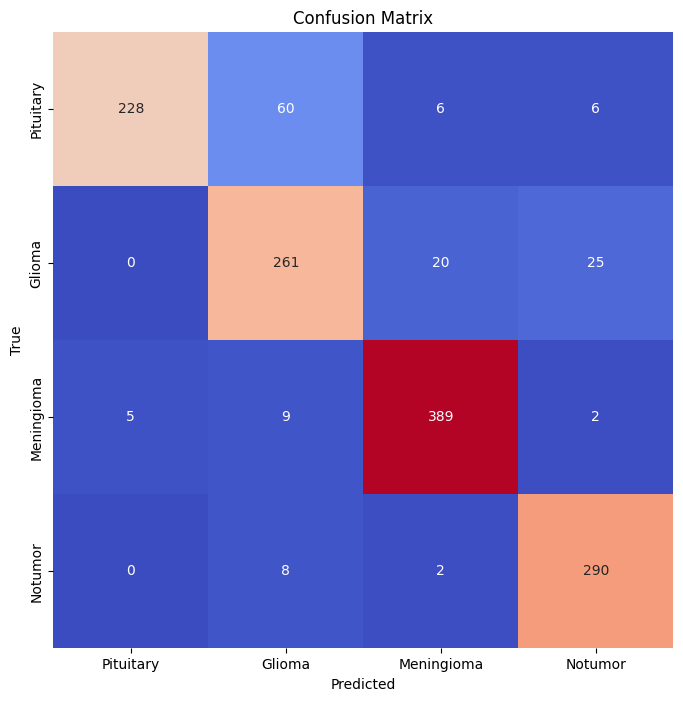

In [40]:
# Plotting confusion matrix
confusion_matrix = CM(model=model_vgg19, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

Inception_V3

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 525,764 (2.01 MB)

 Non-trainable params: 21,802,592 (83.17 MB)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 374ms/step - accuracy: 0.5293 - loss: 1.2918 - val_accuracy: 0.7205 - val_loss: 0.7575
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - accuracy: 0.7867 - loss: 0.5516 - val_accuracy: 0.7123 - val_loss: 0.7253


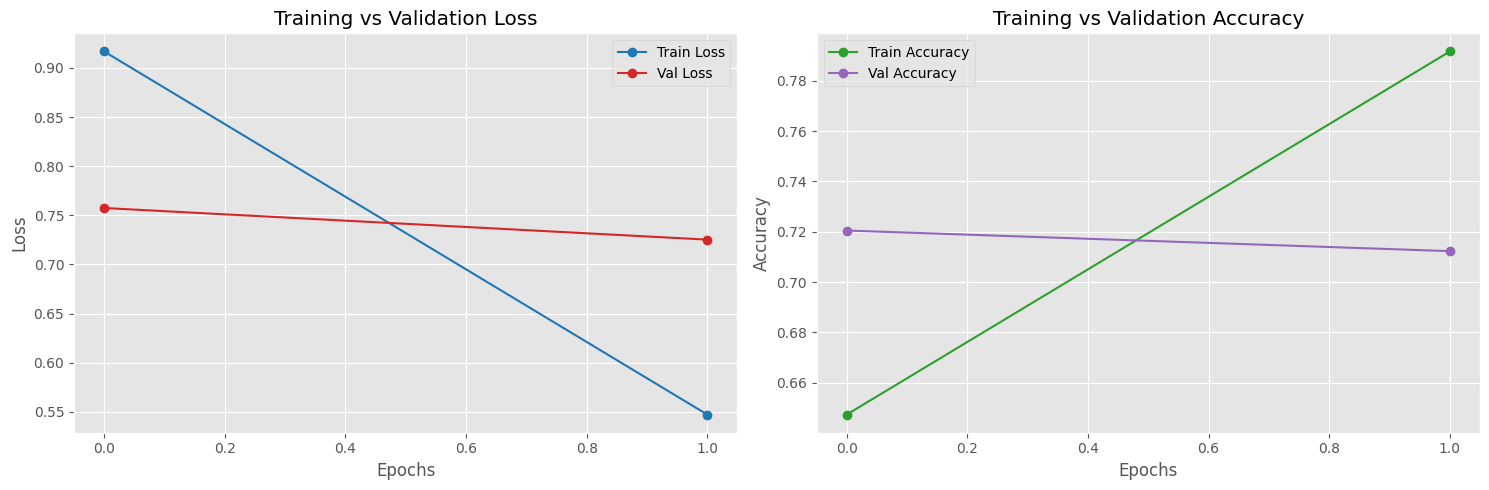

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.7014 - loss: 0.7826
 Test Loss     : 0.59814
 Test Accuracy : 0.77651
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step
Classification Report for <Functional name=functional_2, built=True>:
              precision    recall  f1-score   support

   pituitary       0.82      0.72      0.76       300
      glioma       0.70      0.45      0.54       306
  meningioma       0.89      0.93      0.91       405
     notumor       0.68      0.96      0.79       300

    accuracy                           0.78      1311
   macro avg       0.77      0.76      0.75      1311
weighted avg       0.78      0.78      0.77      1311



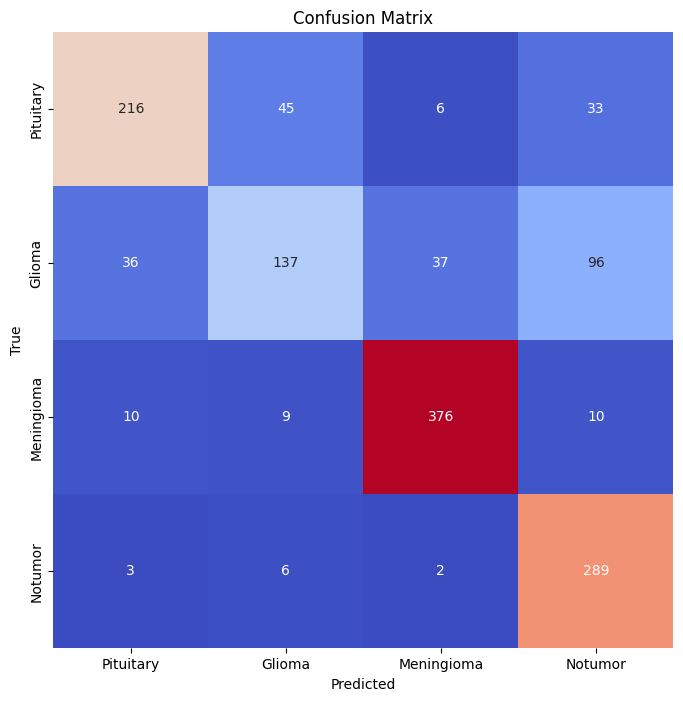

In [41]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 base model with pretrained ImageNet weights, exclude top layers
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers except last 10 layers
for layer in base_model_inception.layers[:-10]:
    layer.trainable = False

for layer in base_model_inception.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_inception = Model(inputs=base_model_inception.input, outputs=output)

# Compile the model
model_inception.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary
model_inception.summary()

inception_history = model_inception.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

plot_curves(inception_history)
loss, accuracy = model_inception.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

# Plotting confusion matrix
confusion_matrix = CM(model=model_inception, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

Xception

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        512 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 6,021,892 (22.97 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 92s 461ms/step - accuracy: 0.6897 - loss: 0.7999 - val_accuracy: 0.7906 - val_loss: 0.6884
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - accuracy: 0.9045 - loss: 0.2750 - val_accuracy: 0.8596 - val_loss: 0.3533


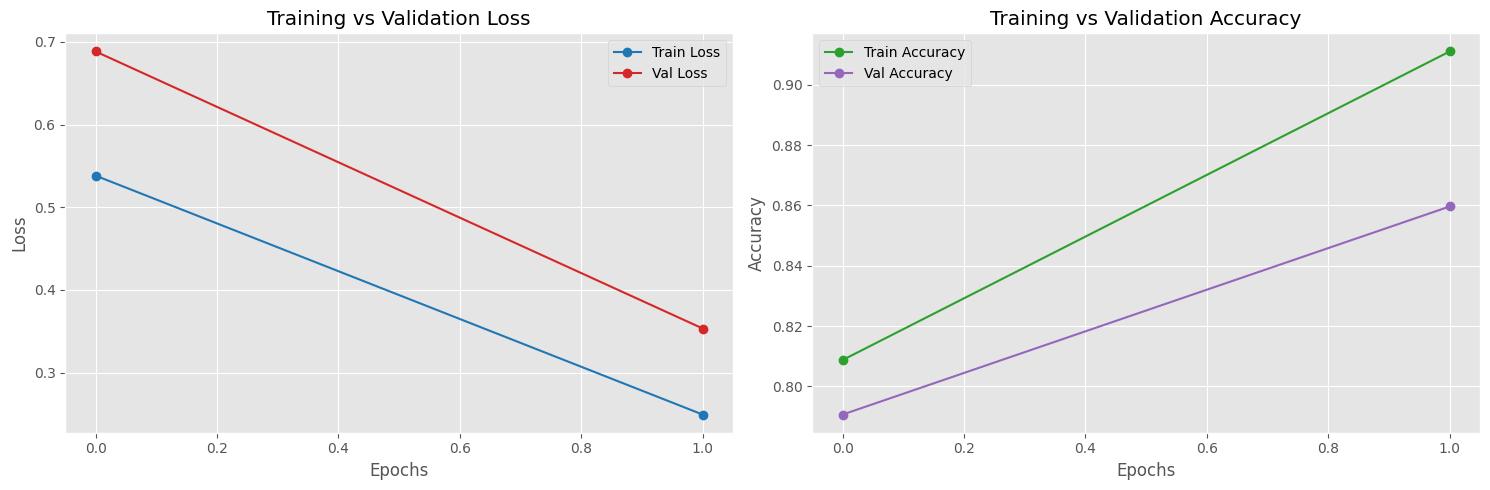

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.8613 - loss: 0.3423
 Test Loss     : 0.25575
 Test Accuracy : 0.90008
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step
Classification Report for <Functional name=functional_3, built=True>:
              precision    recall  f1-score   support

   pituitary       0.94      0.85      0.89       300
      glioma       0.83      0.80      0.81       306
  meningioma       0.93      0.97      0.95       405
     notumor       0.89      0.96      0.92       300

    accuracy                           0.90      1311
   macro avg       0.90      0.89      0.90      1311
weighted avg       0.90      0.90      0.90      1311



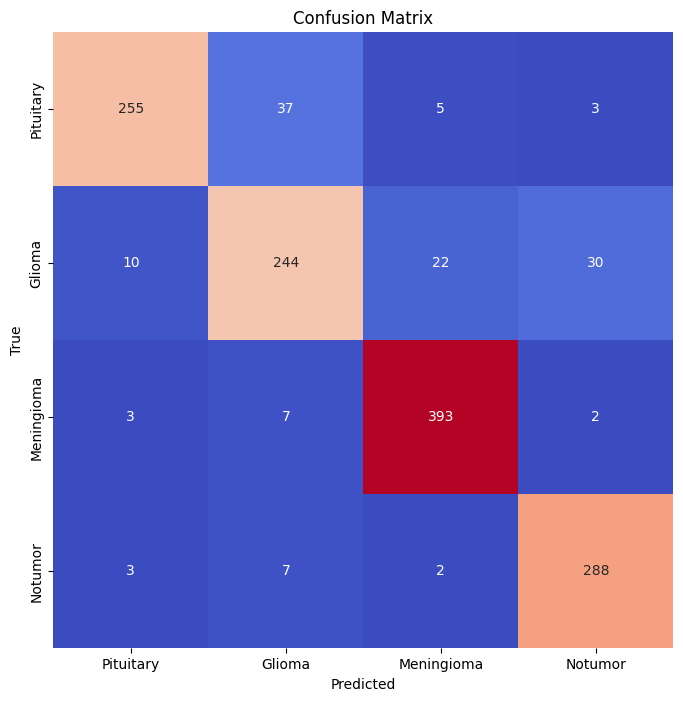

In [42]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the Xception base model with pretrained ImageNet weights, exclude top layers
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers except last 10 layers
for layer in base_model_xception.layers[:-10]:
    layer.trainable = False

for layer in base_model_xception.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_xception = Model(inputs=base_model_xception.input, outputs=output)

# Compile the model
model_xception.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary
model_xception.summary()

xception_history = model_xception.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

plot_curves(xception_history)
loss, accuracy = model_xception.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

# Plotting confusion matrix
confusion_matrix = CM(model=model_xception, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], va='center')
plt.show()

## ResNet101 Model

In [43]:
base_model_resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


# for layer in base_model_resnet.layers[:-10]:
#     layer.trainable = False

# for layer in base_model_resnet.layers[-10:]:
#     layer.trainable = True


# Add custom classification head
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=output)

model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_resnet.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 43,709,316 (166.74 MB)

 Trainable params: 43,603,972 (166.34 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [44]:
resnet_history = model_resnet.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 206s 691ms/step - accuracy: 0.7923 - loss: 0.5612 - val_accuracy: 0.2655 - val_loss: 4.5506
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 351ms/step - accuracy: 0.9499 - loss: 0.1655 - val_accuracy: 0.3357 - val_loss: 1.4210


### ResNet101 Model Evaluation

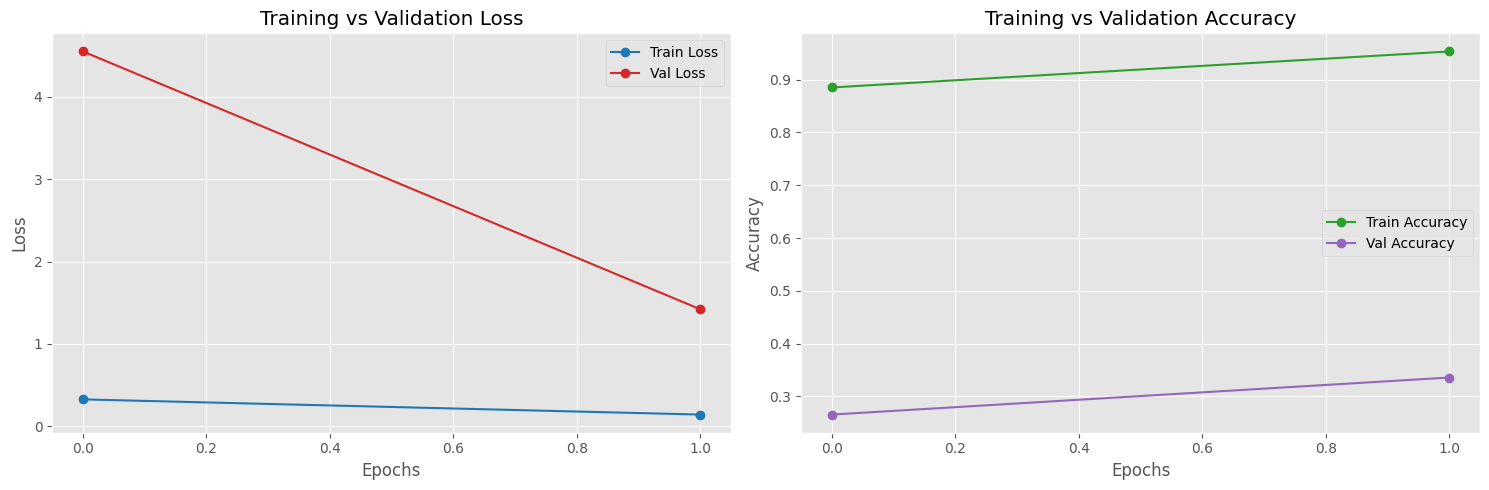

In [45]:
plot_curves(resnet_history)

In [46]:
loss, accuracy = model_resnet.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.5509 - loss: 1.1588
Test Loss: 1.41907
Test Accuracy: 0.36156


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step
Classification Report for <Functional name=functional_4, built=True>:
              precision    recall  f1-score   support

   pituitary       0.30      0.85      0.45       300
      glioma       0.17      0.00      0.01       306
  meningioma       0.47      0.54      0.50       405
     notumor       0.00      0.00      0.00       300

    accuracy                           0.36      1311
   macro avg       0.23      0.35      0.24      1311
weighted avg       0.25      0.36      0.26      1311



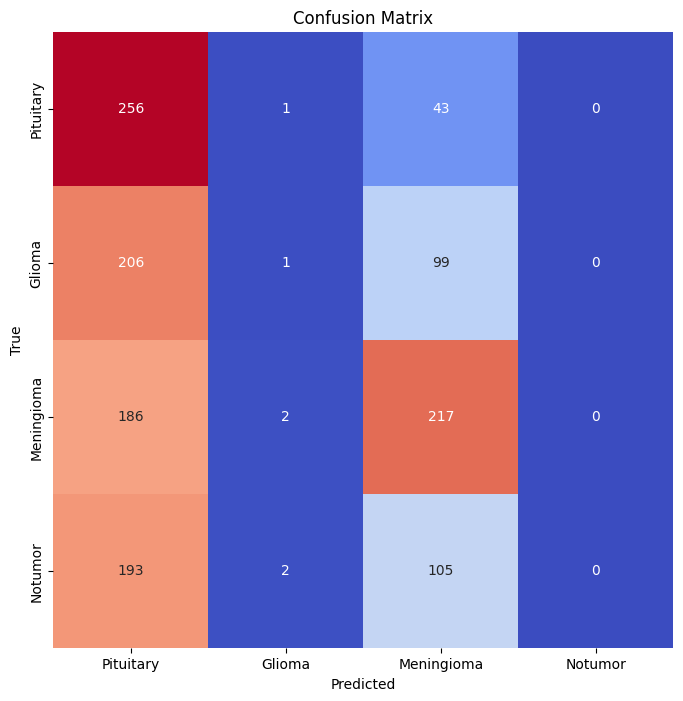

In [47]:
# Plotting confusion matrix
confusion_matrix = CM(model=model_resnet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 1,222,196 (4.66 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 95s 443ms/step - accuracy: 0.2760 - loss: 1.4073 - val_accuracy: 0.2795 - val_loss: 1.3869
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 93s 236ms/step - accuracy: 0.3123 - loss: 1.3738 - val_accuracy: 0.2795 - val_loss: 1.3685


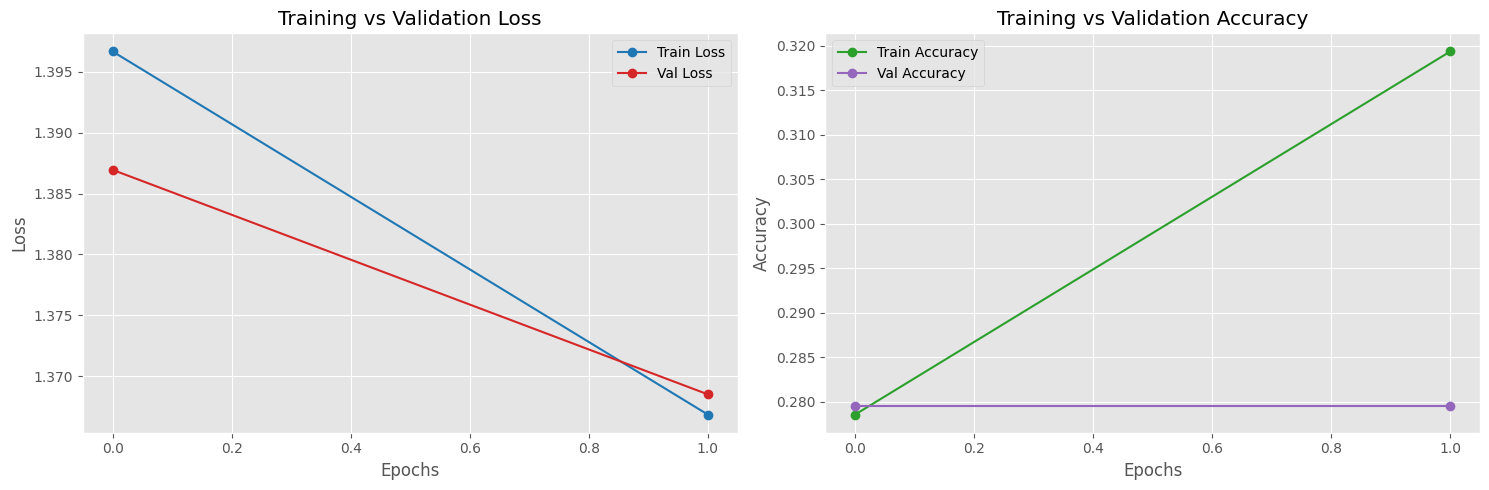

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step - accuracy: 0.1600 - loss: 1.4245
 Test Loss     : 1.36161
 Test Accuracy : 0.30892
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step
Classification Report for <Functional name=functional_5, built=True>:
              precision    recall  f1-score   support

   pituitary       0.00      0.00      0.00       300
      glioma       0.00      0.00      0.00       306
  meningioma       0.31      1.00      0.47       405
     notumor       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



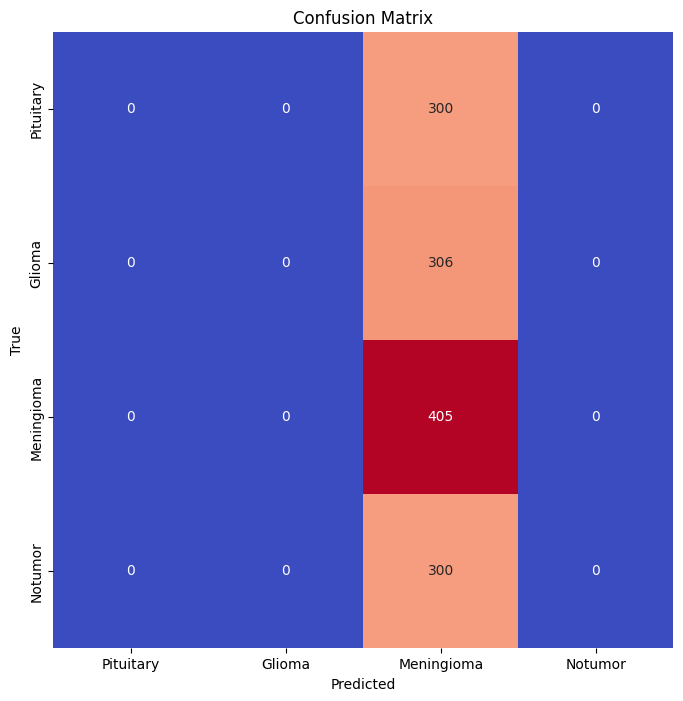

In [48]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 base model with pretrained ImageNet weights, exclude top layers
base_model_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers except last 10 layers
for layer in base_model_effnet.layers[:-10]:
    layer.trainable = False

for layer in base_model_effnet.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_effnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_effnet = Model(inputs=base_model_effnet.input, outputs=output)

# Compile the model
model_effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary
model_effnet.summary()

effnet_history = model_effnet.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

plot_curves(effnet_history)
loss, accuracy = model_effnet.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

# Plotting confusion matrix
confusion_matrix = CM(model=model_effnet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], va='center')
plt.show()


InceptionResNetV2

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 74, 74,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 72, 72,    │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_99[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_100[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 35, 35,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_101[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_102[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 54,731,236 (208.78 MB)

 Trainable params: 4,525,284 (17.26 MB)

 Non-trainable params: 50,205,952 (191.52 MB)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 101s 473ms/step - accuracy: 0.6801 - loss: 0.8030 - val_accuracy: 0.7602 - val_loss: 0.6458
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.8643 - loss: 0.3873 - val_accuracy: 0.8000 - val_loss: 0.5424


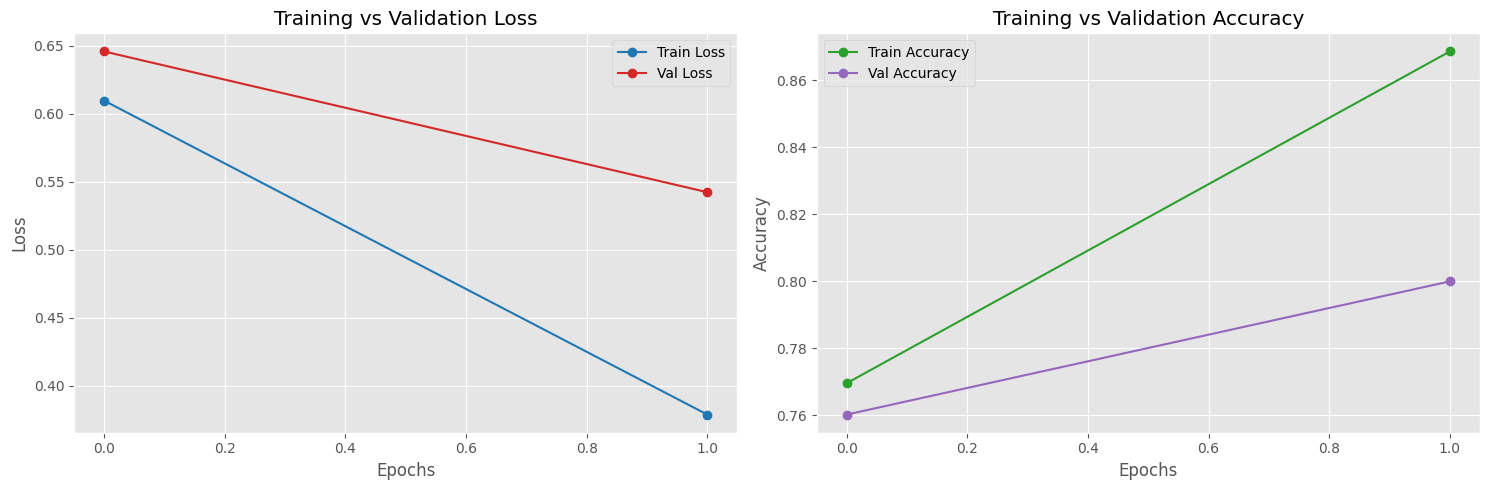

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.7727 - loss: 0.5497
 Test Loss     : 0.42252
 Test Accuracy : 0.82685
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 347ms/step
Classification Report for <Functional name=functional_6, built=True>:
              precision    recall  f1-score   support

   pituitary       0.84      0.83      0.84       300
      glioma       0.84      0.54      0.65       306
  meningioma       0.92      0.93      0.92       405
     notumor       0.72      0.98      0.83       300

    accuracy                           0.83      1311
   macro avg       0.83      0.82      0.81      1311
weighted avg       0.84      0.83      0.82      1311



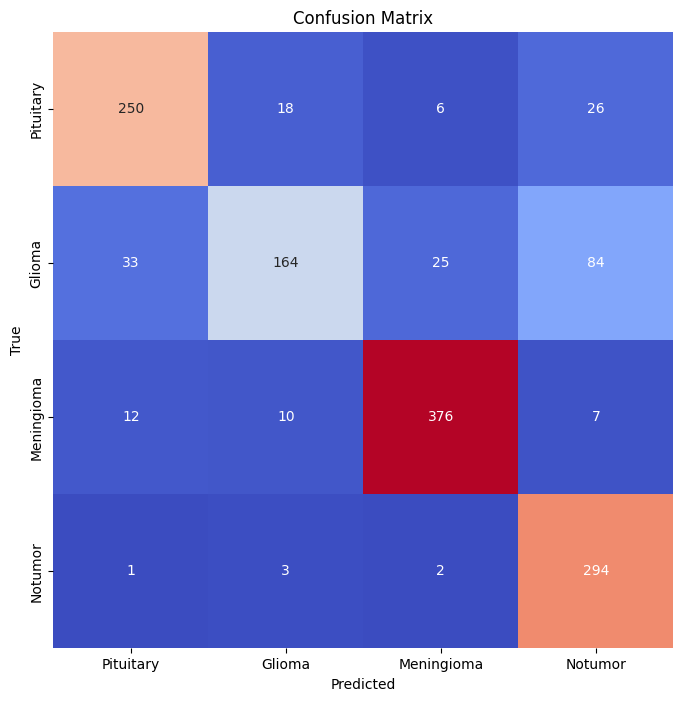

In [49]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load InceptionResNetV2 base model with pretrained ImageNet weights, exclude top layers
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


# Freeze all layers except last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True


# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)


# Final model assembly
model = Model(inputs=base_model.input, outputs=output)


# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Print summary
model.summary()


# Train the model
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)


# Plot training curves (assumes plot_curves function exists)
plot_curves(history)


# Evaluate model on test set
loss, accuracy = model.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")


# Plotting confusion matrix (assumes CM function and classes list are defined)
confusion_matrix = CM(model=model, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], va='center')
plt.show()

## MobileNetV2

In [50]:
# Load the MobileNetV2 base model with pretrained ImageNet weights
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze most layers to leverage pretrained features
for layer in base_model_mobilenet.layers[:-10]:
    layer.trainable = False

for layer in base_model_mobilenet.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=output)

# Compile the model
model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary
model_mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 1,061,444 (4.05 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [51]:
mobilenet_history = model_mobilenet.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 85s 445ms/step - accuracy: 0.6395 - loss: 0.8621 - val_accuracy: 0.7439 - val_loss: 0.7308
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 233ms/step - accuracy: 0.8825 - loss: 0.3231 - val_accuracy: 0.7380 - val_loss: 0.8785


## MobileNetV2 Model Evaluation

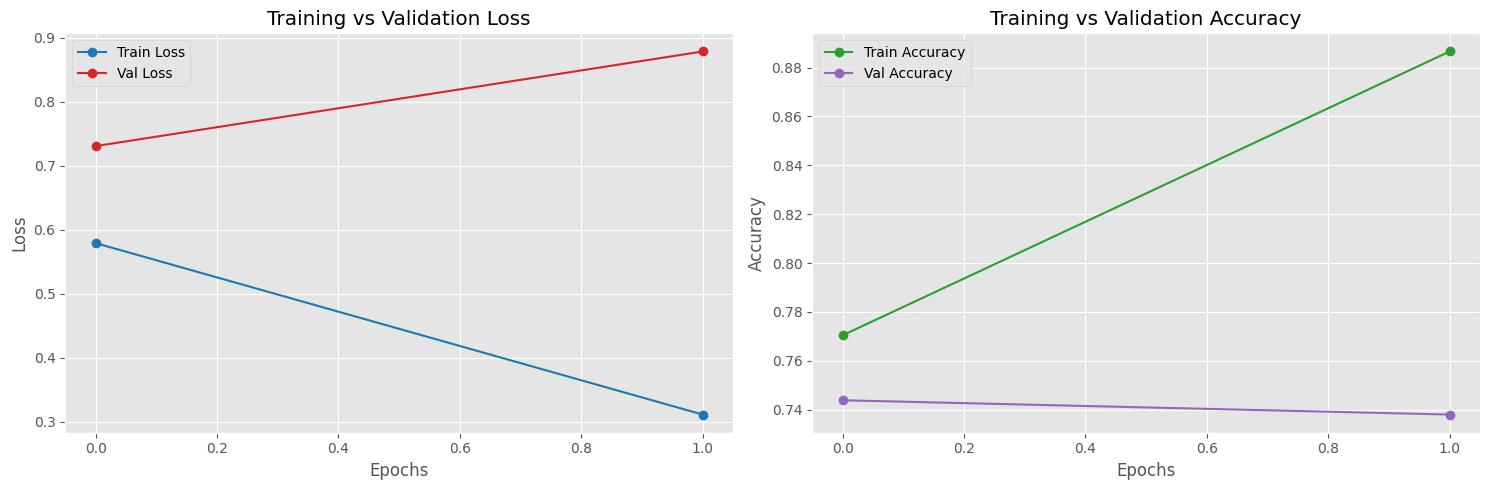

In [52]:
plot_curves(mobilenet_history)

In [53]:
loss, accuracy = model_mobilenet.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.6453 - loss: 1.2074
 Test Loss     : 0.72746
 Test Accuracy : 0.78032


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step
Classification Report for <Functional name=functional_7, built=True>:
              precision    recall  f1-score   support

   pituitary       0.98      0.45      0.62       300
      glioma       0.53      0.82      0.65       306
  meningioma       0.92      0.92      0.92       405
     notumor       0.89      0.88      0.89       300

    accuracy                           0.78      1311
   macro avg       0.83      0.77      0.77      1311
weighted avg       0.84      0.78      0.78      1311



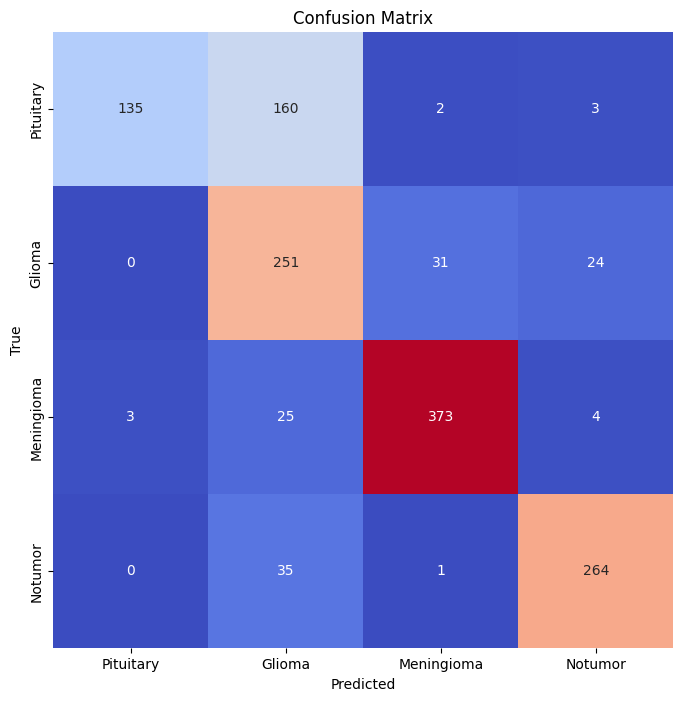

In [54]:
# Plotting confusion matrix
confusion_matrix = CM(model=model_mobilenet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

InceptionResNetV2

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_301 (Conv2D) │ (None, 74, 74,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_301[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_297      │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_302 (Conv2D) │ (None, 72, 72,    │      9,216 │ activation_297[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_302[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_298      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_303 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_298[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_303[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_299      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 35, 35,    │          0 │ activation_299[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_304 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_304[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_300      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_305 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_300[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_305[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_301      │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 54,731,236 (208.78 MB)

 Trainable params: 4,525,284 (17.26 MB)

 Non-trainable params: 50,205,952 (191.52 MB)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 97s 452ms/step - accuracy: 0.6964 - loss: 0.7922 - val_accuracy: 0.7474 - val_loss: 0.7114
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - accuracy: 0.8511 - loss: 0.3935 - val_accuracy: 0.8012 - val_loss: 0.5138


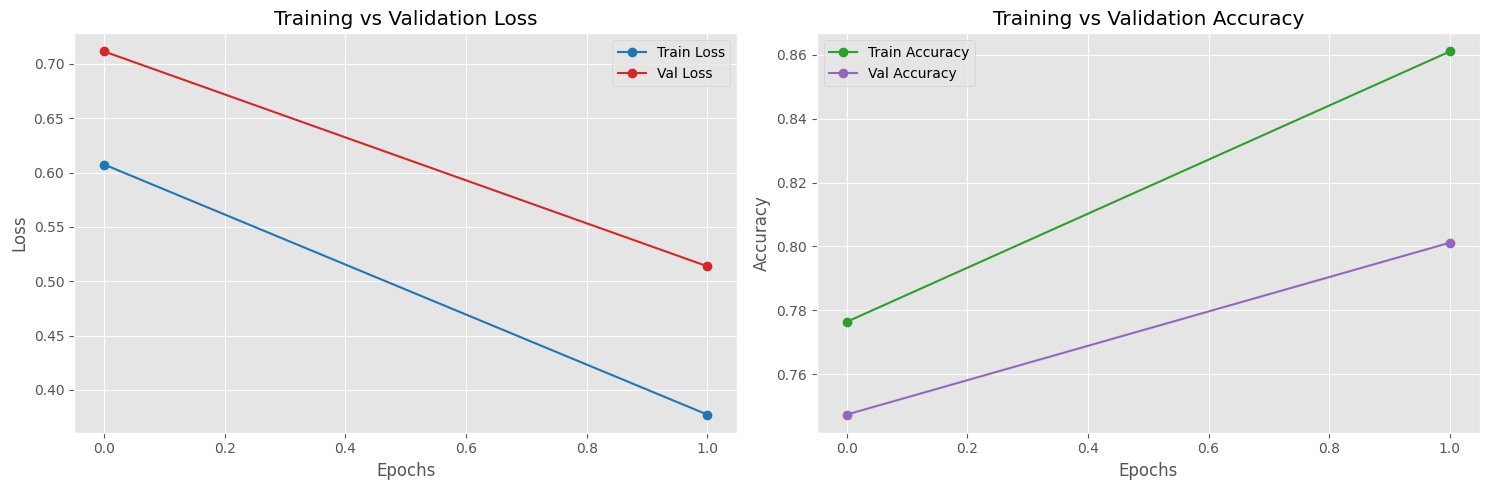

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.8073 - loss: 0.4867
 Test Loss     : 0.37452
 Test Accuracy : 0.86194
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 349ms/step
Classification Report for <Functional name=functional_8, built=True>:
              precision    recall  f1-score   support

   pituitary       0.91      0.81      0.85       300
      glioma       0.78      0.72      0.75       306
  meningioma       0.96      0.92      0.94       405
     notumor       0.79      0.98      0.88       300

    accuracy                           0.86      1311
   macro avg       0.86      0.86      0.85      1311
weighted avg       0.87      0.86      0.86      1311



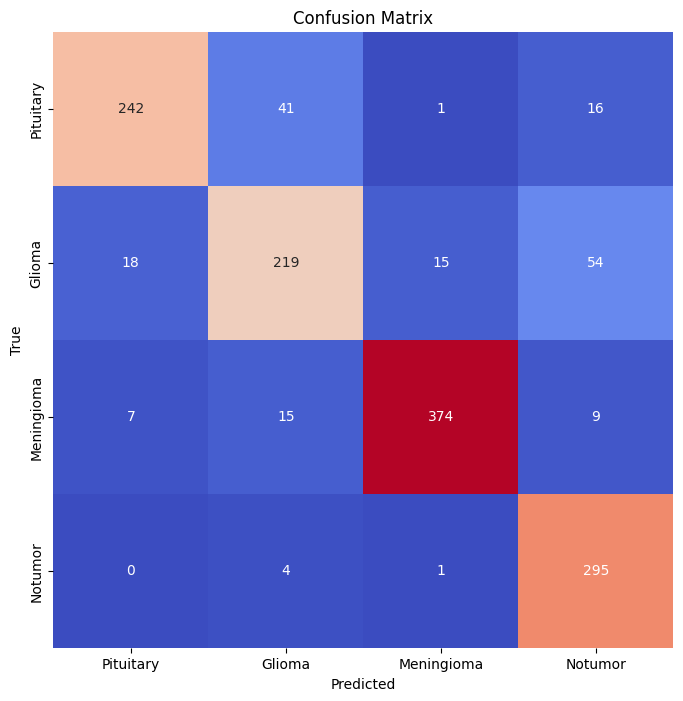

In [55]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the InceptionResNetV2 base model with pretrained ImageNet weights, exclude top layers
base_model_incep_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers except last 10 layers
for layer in base_model_incep_resnet.layers[:-10]:
    layer.trainable = False

for layer in base_model_incep_resnet.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_incep_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_incep_resnet = Model(inputs=base_model_incep_resnet.input, outputs=output)

# Compile the model
model_incep_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary
model_incep_resnet.summary()

# Train the model
incep_resnet_history = model_incep_resnet.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

# Plot training curves
plot_curves(incep_resnet_history)

# Evaluate the model on test data
loss, accuracy = model_incep_resnet.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

# Plotting confusion matrix
confusion_matrix = CM(model=model_incep_resnet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

DenseNet121

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 156, 156,  │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 38, 38,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 38, 38,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 38, 38,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 38, 38,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 38, 38,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 431,556 (1.65 MB)

 Non-trainable params: 6,869,376 (26.20 MB)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 109s 523ms/step - accuracy: 0.5187 - loss: 1.2440 - val_accuracy: 0.7333 - val_loss: 0.7484
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 45s 295ms/step - accuracy: 0.8249 - loss: 0.4748 - val_accuracy: 0.7649 - val_loss: 0.6392


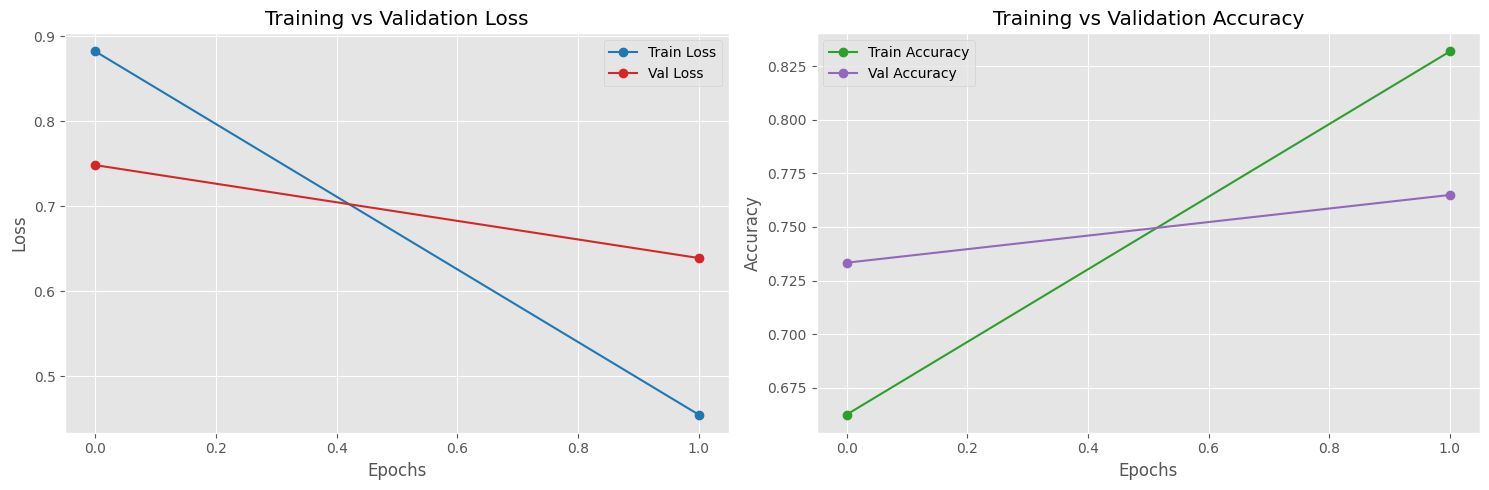

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 385ms/step - accuracy: 0.7450 - loss: 0.6403
 Test Loss     : 0.46943
 Test Accuracy : 0.82914
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step
Classification Report for <Functional name=functional_9, built=True>:
              precision    recall  f1-score   support

   pituitary       0.95      0.75      0.84       300
      glioma       0.73      0.61      0.66       306
  meningioma       0.92      0.94      0.93       405
     notumor       0.73      0.99      0.84       300

    accuracy                           0.83      1311
   macro avg       0.83      0.82      0.82      1311
weighted avg       0.84      0.83      0.83      1311



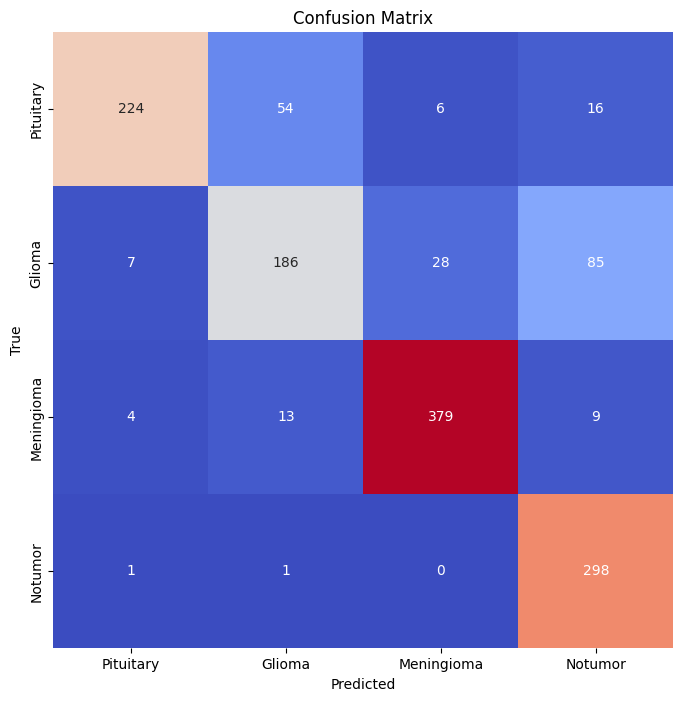

In [56]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the DenseNet121 base model with pretrained ImageNet weights, exclude top layers
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers except last 10 layers
for layer in base_model_densenet.layers[:-10]:
    layer.trainable = False

for layer in base_model_densenet.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_densenet = Model(inputs=base_model_densenet.input, outputs=output)

# Compile the model
model_densenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_densenet.summary()

# Train the model
densenet_history = model_densenet.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

# Plot training curves
plot_curves(densenet_history)

# Evaluate the model on test data
loss, accuracy = model_densenet.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

# Plotting confusion matrix
confusion_matrix = CM(model=model_densenet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()


MobileNet1

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 75, 75, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 75, 75, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 75, 75, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 75, 75, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 37, 37, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 37, 37, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 37, 37, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 37, 37, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,492,292 (13.32 MB)

 Trainable params: 1,851,652 (7.06 MB)

 Non-trainable params: 1,640,640 (6.26 MB)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 73s 394ms/step - accuracy: 0.6735 - loss: 0.8683 - val_accuracy: 0.7813 - val_loss: 0.6362
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 40s 262ms/step - accuracy: 0.9003 - loss: 0.2892 - val_accuracy: 0.8620 - val_loss: 0.3834


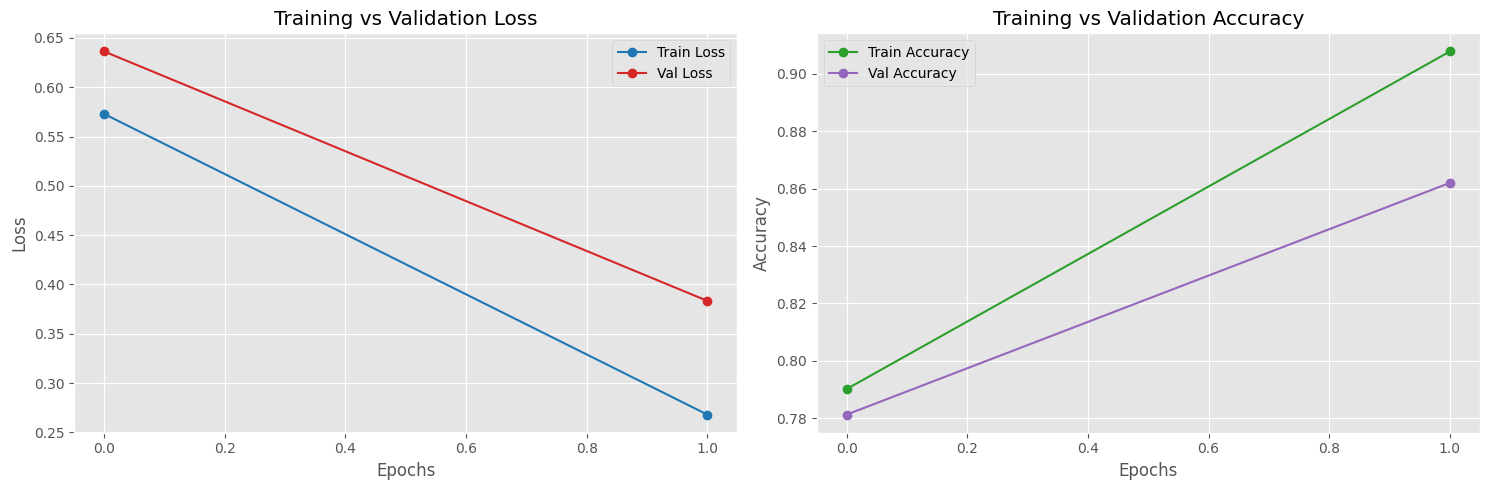

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 0.8422 - loss: 0.4699
 Test Loss     : 0.29819
 Test Accuracy : 0.90236
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step
Classification Report for <Functional name=functional_10, built=True>:
              precision    recall  f1-score   support

   pituitary       0.99      0.77      0.86       300
      glioma       0.78      0.86      0.82       306
  meningioma       0.98      0.97      0.97       405
     notumor       0.87      0.99      0.93       300

    accuracy                           0.90      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311



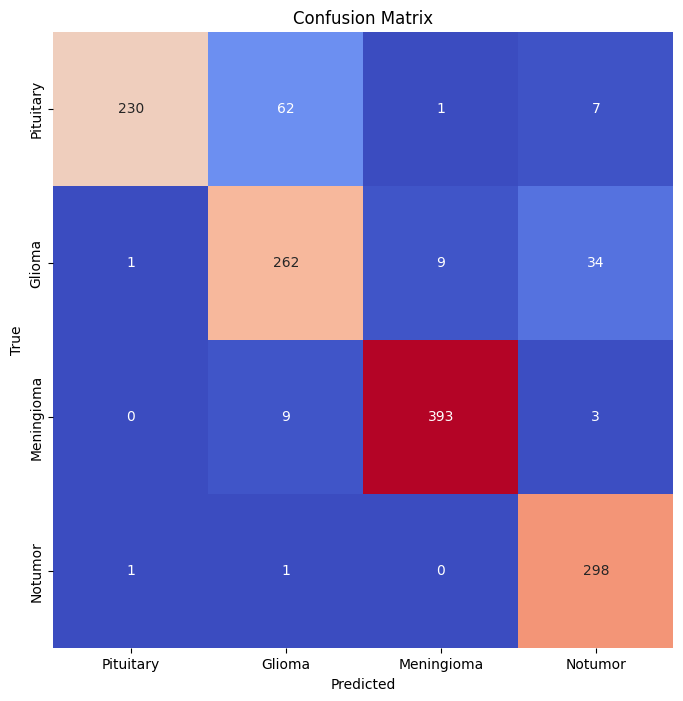

In [57]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the MobileNet (V1) base model with pretrained ImageNet weights, exclude top layers
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers except last 10 layers
for layer in base_model_mobilenet.layers[:-10]:
    layer.trainable = False

for layer in base_model_mobilenet.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=output)

# Compile the model
model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_mobilenet.summary()

# Train the model
mobilenet_history = model_mobilenet.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

# Plot training curves
plot_curves(mobilenet_history)

# Evaluate the model on test data
loss, accuracy = model_mobilenet.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

# Plotting confusion matrix
confusion_matrix = CM(model=model_mobilenet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

DenseNet121

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 156, 156,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 38, 38,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 38, 38,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 38, 38,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 38, 38,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 38, 38,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 431,556 (1.65 MB)

 Non-trainable params: 6,869,376 (26.20 MB)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 625s 577ms/step - accuracy: 0.5245 - loss: 1.2269 - val_accuracy: 0.6959 - val_loss: 0.8328
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 48s 318ms/step - accuracy: 0.8147 - loss: 0.5241 - val_accuracy: 0.7591 - val_loss: 0.6643


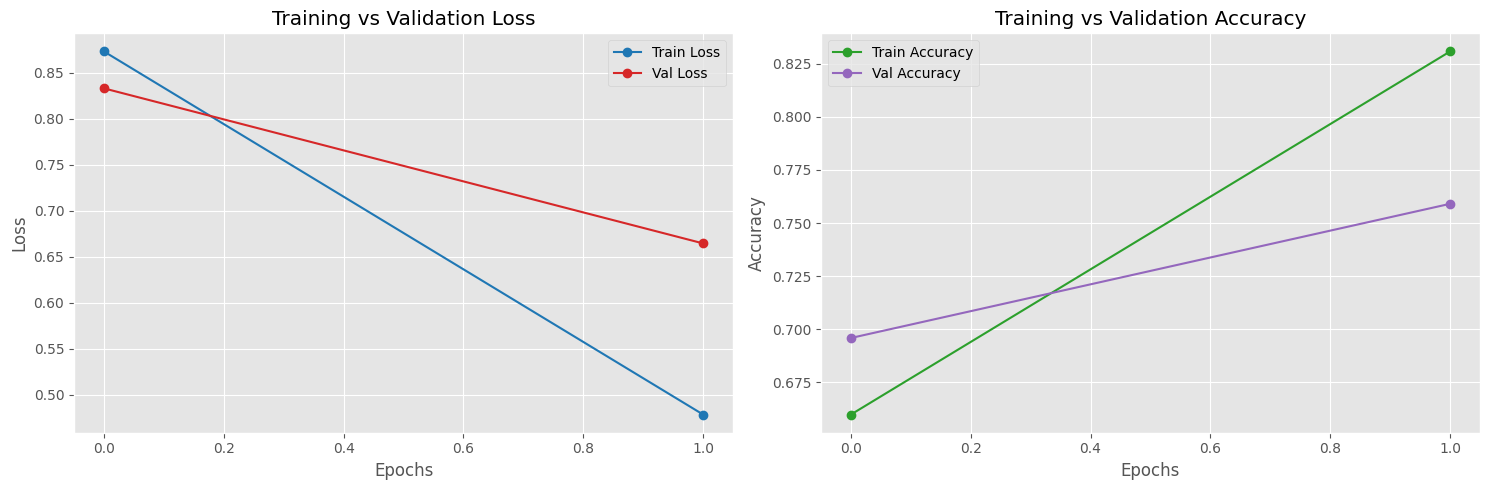

40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7323 - loss: 0.6581

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the DenseNet121 base model with pretrained ImageNet weights, exclude top layers
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers except last 10 layers
for layer in base_model_densenet.layers[:-10]:
    layer.trainable = False

for layer in base_model_densenet.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model assembly
model_densenet = Model(inputs=base_model_densenet.input, outputs=output)

# Compile the model
model_densenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_densenet.summary()

# Train the model
densenet_history = model_densenet.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

# Plot training curves
plot_curves(densenet_history)

# Evaluate the model on test data
loss, accuracy = model_densenet.evaluate(test_generator)
print(f" Test Loss     : {loss:.5f}")
print(f" Test Accuracy : {accuracy:.5f}")

# Plotting confusion matrix
confusion_matrix = CM(model=model_densenet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# -----------------------------------------------
# Function to evaluate a model
# -----------------------------------------------
def evaluate_model(model, name, test_generator):
    """Evaluates the model, prints accuracy/loss, and returns results."""
    loss, accuracy = model.evaluate(test_generator, verbose=0)
    y_pred = np.argmax(model.predict(test_generator, verbose=0), axis=1)
    y_true = test_generator.classes
    print(f"\n📊 {name} Evaluation:")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"📉 Loss    : {loss:.4f}")
    return {
        "name": name,
        "loss": loss,
        "accuracy": accuracy,
        "y_true": y_true,
        "y_pred": y_pred,
        "conf_matrix": confusion_matrix(y_true, y_pred)
    }


# -----------------------------------------------
# Evaluate all models
# -----------------------------------------------
results = []
results.append(evaluate_model(model_vgg16, "VGG16", test_generator))
results.append(evaluate_model(model_vgg19, "VGG19", test_generator))
results.append(evaluate_model(model_resnet, "ResNet101", test_generator))
results.append(evaluate_model(model_mobilenet, "MobileNetV2", test_generator))
results.append(evaluate_model(model_inception, "InceptionV3", test_generator))
results.append(evaluate_model(model_xception, "Xception", test_generator))
results.append(evaluate_model(model_effnet, "EfficientNet", test_generator))
results.append(evaluate_model(model_incep_resnet, "InceptionResNetV2", test_generator))
results.append(evaluate_model(model_densenet, "DenseNet121", test_generator))
results.append(evaluate_model(model_mobilenet, "MobileNetV1", test_generator))

# -----------------------------------------------
# Build accuracy result dictionary
# -----------------------------------------------
THE_ALL_RESULTS = {r['name']: r['accuracy'] for r in results}


# -----------------------------------------------
# Print accuracy values
# -----------------------------------------------
print("\nAccuracy values:")
for model, accuracy in THE_ALL_RESULTS.items():
    print(f"{model}: {accuracy:.4f}")


# -----------------------------------------------
# Plot bar chart of model accuracies with seaborn palette
# -----------------------------------------------
plt.figure(figsize=(8, 5))

colors = sns.color_palette("Set2", n_colors=len(THE_ALL_RESULTS))
bars = plt.bar(THE_ALL_RESULTS.keys(), THE_ALL_RESULTS.values(), color=colors)

# Add value labels on top of bars
for bar, (model, accuracy) in zip(bars, THE_ALL_RESULTS.items()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
             f'{accuracy:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Model Accuracy Comparison', fontsize=20)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max(THE_ALL_RESULTS.values()) * 1.1)
plt.tight_layout()
plt.show()

NameError: name 'model_vgg16' is not defined